# IMPORTS

In [9]:
import numpy as np # linear algebra
import pandas as pd
import tensorflow as tf
import glob
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow.keras.models import Model

# Model Settings 

In [24]:
FINE_TUNING_EPOCHS = 7
TRAINING_EPOCHS = 3
BATCH_SIZE = 32

image_height = 256
image_width = 256

# Load data

In [25]:
# Make objects with the images and masks. 
brain_scans = []
mask_files = glob.glob(r"C:\Users\edecr\Desktop\Project\project\data\braindata\lgg-mri-segmentation\kaggle_3m/*/*_mask*")


for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

In [26]:
# Make a dataframe with the images and their corresponding masks
data_df = pd.DataFrame({"image_path":brain_scans, "mask_path":mask_files})
data_df

image_path  \
0     C:\Users\edecr\Desktop\Project\project\data\br...   
1     C:\Users\edecr\Desktop\Project\project\data\br...   
2     C:\Users\edecr\Desktop\Project\project\data\br...   
3     C:\Users\edecr\Desktop\Project\project\data\br...   
4     C:\Users\edecr\Desktop\Project\project\data\br...   
...                                                 ...   
3924  C:\Users\edecr\Desktop\Project\project\data\br...   
3925  C:\Users\edecr\Desktop\Project\project\data\br...   
3926  C:\Users\edecr\Desktop\Project\project\data\br...   
3927  C:\Users\edecr\Desktop\Project\project\data\br...   
3928  C:\Users\edecr\Desktop\Project\project\data\br...   

                                              mask_path  
0     C:\Users\edecr\Desktop\Project\project\data\br...  
1     C:\Users\edecr\Desktop\Project\project\data\br...  
2     C:\Users\edecr\Desktop\Project\project\data\br...  
3     C:\Users\edecr\Desktop\Project\project\data\br...  
4     C:\Users\edecr\Desktop\Project\project\data\br...  
...                                                 ...  
3924  C:\Users\edecr\Desktop\Project\project\data\br...  
3925  C:\Users\edecr\Desktop\Project\project\data\br...  
3926  C:\Users\edecr\Desktop\Project\project\data\br...  
3927  C:\Users\edecr\Desktop\Project\project\data\br...  
3928  C:\Users\edecr\Desktop\Project\project\data\br...  

[3929 rows x 2 columns]

In [27]:
# State if image has tumor or not
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        return 'Has Tumor'
    else:
        return 'Does not have Tumor'

In [28]:
# Apply the function to the masks and return back a column with 1 and zeros, where 0 indicate no tumor and 1 a tumor. 
data_df["tumour"] = data_df["mask_path"].apply(lambda x: positive_negative_diagnosis(x)) 

In [29]:
data_df

image_path  \
0     C:\Users\edecr\Desktop\Project\project\data\br...   
1     C:\Users\edecr\Desktop\Project\project\data\br...   
2     C:\Users\edecr\Desktop\Project\project\data\br...   
3     C:\Users\edecr\Desktop\Project\project\data\br...   
4     C:\Users\edecr\Desktop\Project\project\data\br...   
...                                                 ...   
3924  C:\Users\edecr\Desktop\Project\project\data\br...   
3925  C:\Users\edecr\Desktop\Project\project\data\br...   
3926  C:\Users\edecr\Desktop\Project\project\data\br...   
3927  C:\Users\edecr\Desktop\Project\project\data\br...   
3928  C:\Users\edecr\Desktop\Project\project\data\br...   

                                              mask_path               tumour  
0     C:\Users\edecr\Desktop\Project\project\data\br...  Does not have Tumor  
1     C:\Users\edecr\Desktop\Project\project\data\br...            Has Tumor  
2     C:\Users\edecr\Desktop\Project\project\data\br...            Has Tumor  
3     C:\Users\edecr\Desktop\Project\project\data\br...            Has Tumor  
4     C:\Users\edecr\Desktop\Project\project\data\br...            Has Tumor  
...                                                 ...                  ...  
3924  C:\Users\edecr\Desktop\Project\project\data\br...  Does not have Tumor  
3925  C:\Users\edecr\Desktop\Project\project\data\br...  Does not have Tumor  
3926  C:\Users\edecr\Desktop\Project\project\data\br...  Does not have Tumor  
3927  C:\Users\edecr\Desktop\Project\project\data\br...  Does not have Tumor  
3928  C:\Users\edecr\Desktop\Project\project\data\br...  Does not have Tumor  

[3929 rows x 3 columns]

In [30]:
train_df, test_df  = train_test_split(data_df, test_size = 0.1, stratify = data_df['tumour'] )
train_df, valid_df = train_test_split(train_df,test_size = 0.2, stratify = train_df['tumour'])

# Data Preprocessing 

In [31]:
# Preprocess train data
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = True,
                         zoom_range      = 0.05,
                         rotation_range  = 25)

In [32]:
train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory   = '', # images data path / folder in which images are there
    x_col       = 'image_path',
    y_col       = 'tumour',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 2828 validated image filenames belonging to 2 classes.


In [33]:
#Preprocess test data
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df, # dataframe
    directory   = '', # images data path / folder in which images are there
    x_col       = 'image_path',
    y_col       = 'tumour',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    seed        = 42)

Found 708 validated image filenames belonging to 2 classes.


In [34]:
test_generator = test_gen.flow_from_dataframe(
    test_df, # dataframe
    directory   = '', # images data path / folder in which images are there
    x_col       = 'image_path',
    y_col       = 'tumour',
    color_mode  = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = BATCH_SIZE,
    shuffle     = False)

Found 393 validated image filenames belonging to 2 classes.


In [35]:
# Get labels in dataset
a = train_generator.class_indices
class_names = list(a.keys())  # storing class/breed names in a list
class_names

['Does not have Tumor', 'Has Tumor']

In [14]:
train_freq      = np.unique(train_generator.classes, return_counts=True)
validation_freq = np.unique(validation_generator.classes, return_counts=True)
test_freq       = np.unique(test_generator.classes, return_counts=True)

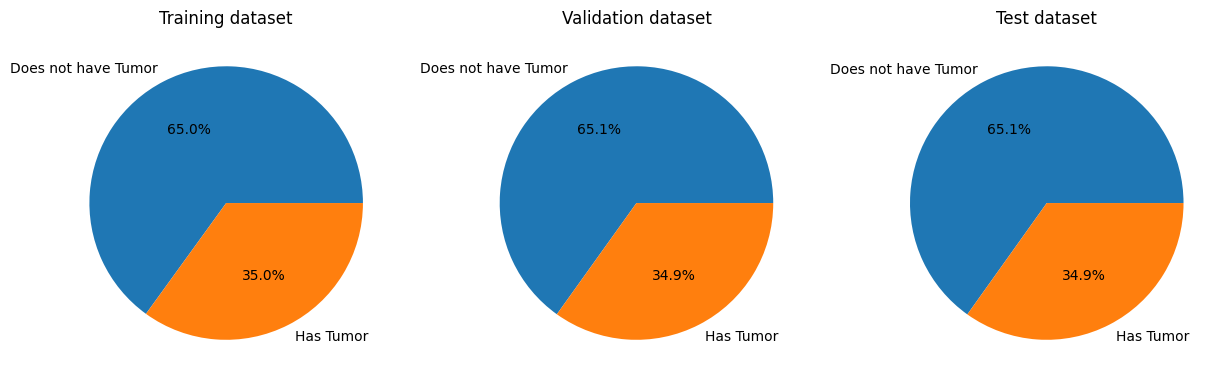

In [15]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
ax[0].set_title("Training dataset")
ax[0].pie(train_freq[1], labels = class_names, autopct='%1.1f%%');
ax[1].set_title("Validation dataset")
ax[1].pie(validation_freq[1], labels = class_names, autopct='%1.1f%%');
ax[2].set_title("Test dataset")
ax[2].pie(test_freq[1], labels = class_names, autopct='%1.1f%%');

In [16]:
# clearly an umbalanced data set so let's some class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))

In [17]:
class_weights

{0: 0.7688961392060902, 1: 1.4297269969666329}

# Get Sample Images

In [18]:
def plot_images(img, true_labels, predictions = None):
    plt.figure(figsize=[12, 18])
    for i in range(24):
        plt.subplot(6, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if (predictions is not None):
            plt.title("{}\n {} {:.1f}%".format(class_names[np.argmax(true_labels[i])], class_names[np.argmax(predictions[i])], 100 * np.max(predictions[i])))
        else:
            plt.title(class_names[np.argmax(true_labels[i])]) 

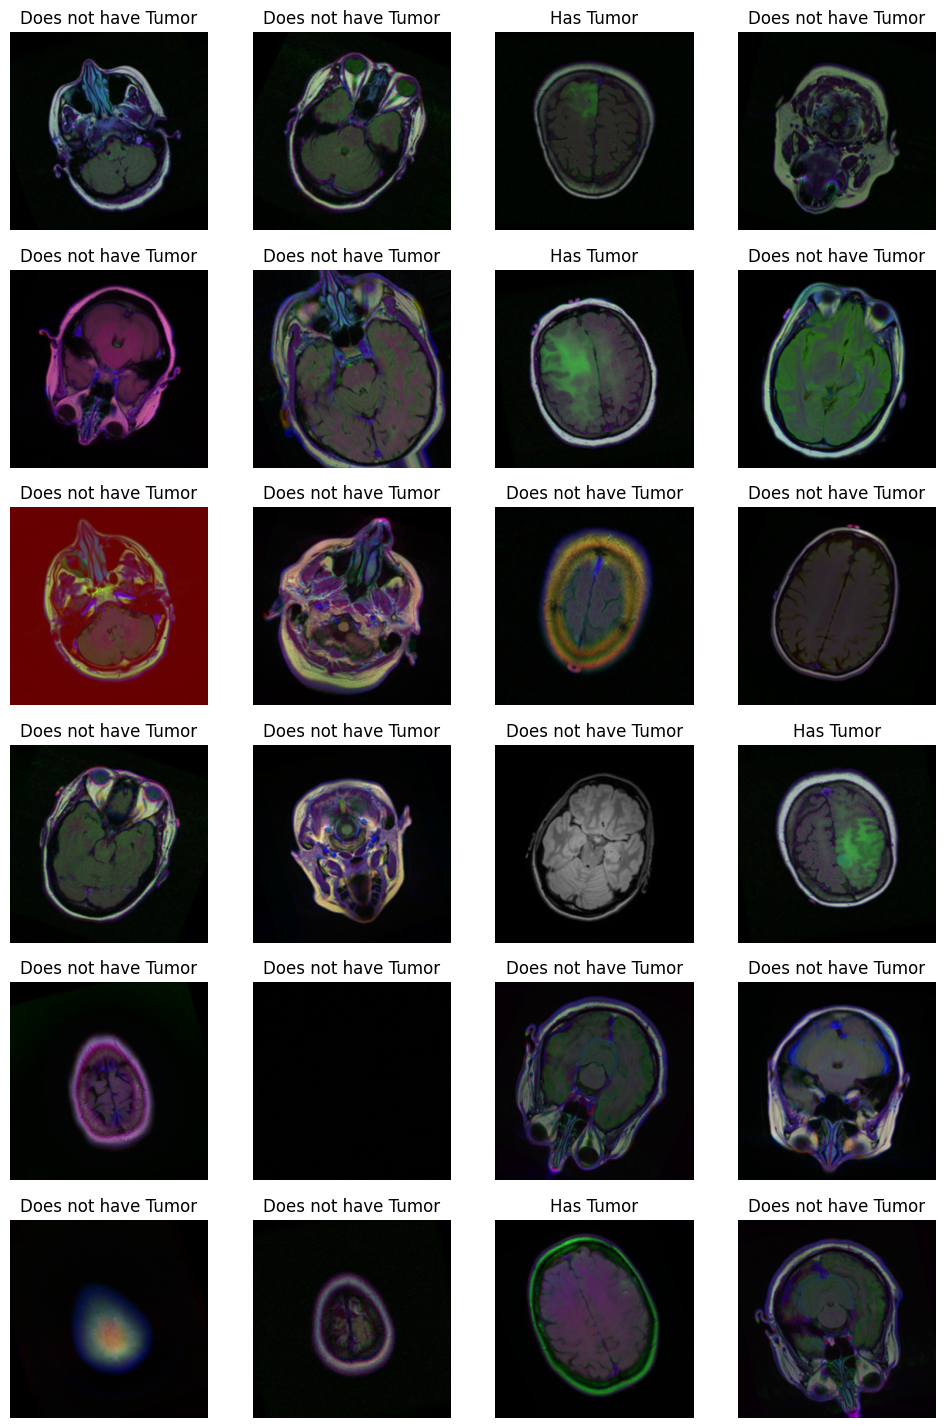

In [19]:
x,y = next(train_generator)
plot_images(x,y)

# Define the Model

In [20]:
def create_model(base_model):
    
    x = base_model.output    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.2)(x)
    
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(base_model.inputs, outputs)
    
    return model  

In [21]:
def fit_model(model, base_model, epochs, fine_tune = 0):
    
    early = tf.keras.callbacks.EarlyStopping( patience = 10,
                                              min_delta = 0.001,
                                              restore_best_weights = True)
    print("Unfreezing number of layers in base model = ", fine_tune)
    
    if fine_tune > 0:
        base_model.trainable = True
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False       
        # small learning rate for fine tuning
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        base_model.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        # fit model
    history = model.fit(train_generator,
                        validation_data = validation_generator,
                        epochs = epochs,
                        callbacks = [early],
                        class_weight=class_weights)
    
    return history

# VGG16 Architecture

In [22]:
# load the VGG16 architecture with imagenet weights as base
vgg16_base_model = tf.keras.applications.vgg16.VGG16(
                             include_top = False,
                             weights = 'imagenet',
                             input_shape = (image_height, image_width, 3)
                             )

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
vgg16_model = create_model(vgg16_base_model)
#vgg16_model.summary()
history_1 = fit_model(vgg16_model, vgg16_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/3
89/89 [==============================] - 1661s 19s/step - loss: 0.5873 - accuracy: 0.6842 - val_loss: 0.6966 - val_accuracy: 0.6582
Epoch 2/3
89/89 [==============================] - 1690s 19s/step - loss: 0.4933 - accuracy: 0.7489 - val_loss: 0.5976 - val_accuracy: 0.6737
Epoch 3/3
89/89 [==============================] - 1688s 19s/step - loss: 0.4714 - accuracy: 0.7539 - val_loss: 0.5230 - val_accuracy: 0.7302


In [23]:
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()


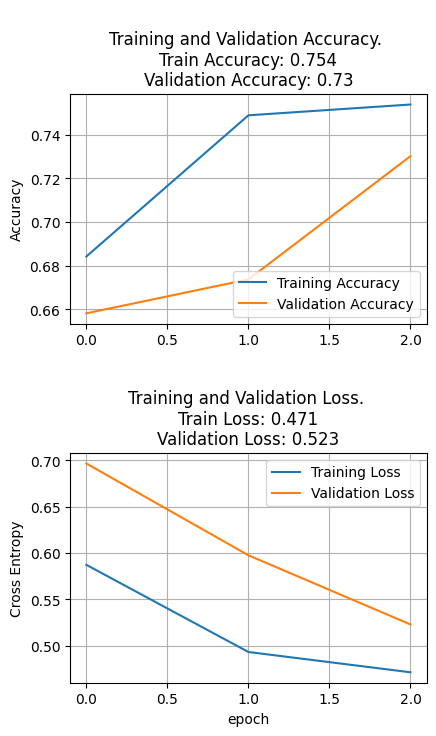

In [24]:
plot_history(history_1)

In [25]:
nr_base_layers = len(vgg16_base_model.layers)
print("VGG16 base layers = ", nr_base_layers)    

history = fit_model(vgg16_model, vgg16_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

VGG16 base layers =  19
Unfreezing number of layers in base model =  4
Epoch 1/7
89/89 [==============================] - 1705s 19s/step - loss: 0.4564 - accuracy: 0.7599 - val_loss: 0.4617 - val_accuracy: 0.7500
Epoch 2/7
89/89 [==============================] - 2838s 32s/step - loss: 0.4293 - accuracy: 0.7698 - val_loss: 0.4503 - val_accuracy: 0.7528
Epoch 3/7
89/89 [==============================] - 3087s 35s/step - loss: 0.4105 - accuracy: 0.7882 - val_loss: 0.4076 - val_accuracy: 0.7684
Epoch 4/7
89/89 [==============================] - 2737s 31s/step - loss: 0.3808 - accuracy: 0.8069 - val_loss: 0.3694 - val_accuracy: 0.8051
Epoch 5/7
89/89 [==============================] - 2927s 33s/step - loss: 0.3450 - accuracy: 0.8327 - val_loss: 0.3190 - val_accuracy: 0.8489
Epoch 6/7
89/89 [==============================] - 2588s 29s/step - loss: 0.3256 - accuracy: 0.8494 - val_loss: 0.3123 - val_accuracy: 0.8446
Epoch 7/7
89/89 [==============================] - 1844s 21s/step - loss: 0.3

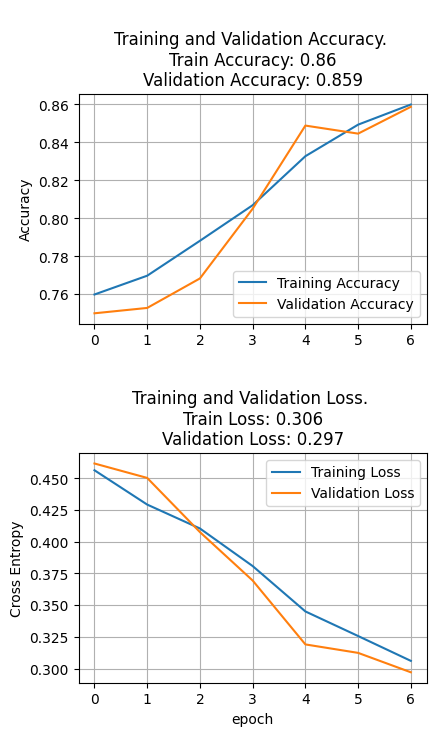

In [26]:
plot_history(history)

In [27]:
accuracy_score = vgg16_model.evaluate(test_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

13/13 [==============================] - 163s 12s/step - loss: 0.3187 - accuracy: 0.8677
[0.31867802143096924, 0.8676844835281372]
Accuracy: 86.77%
Loss: 0.319


In [28]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)

13/13 [==============================] - 201s 15s/step


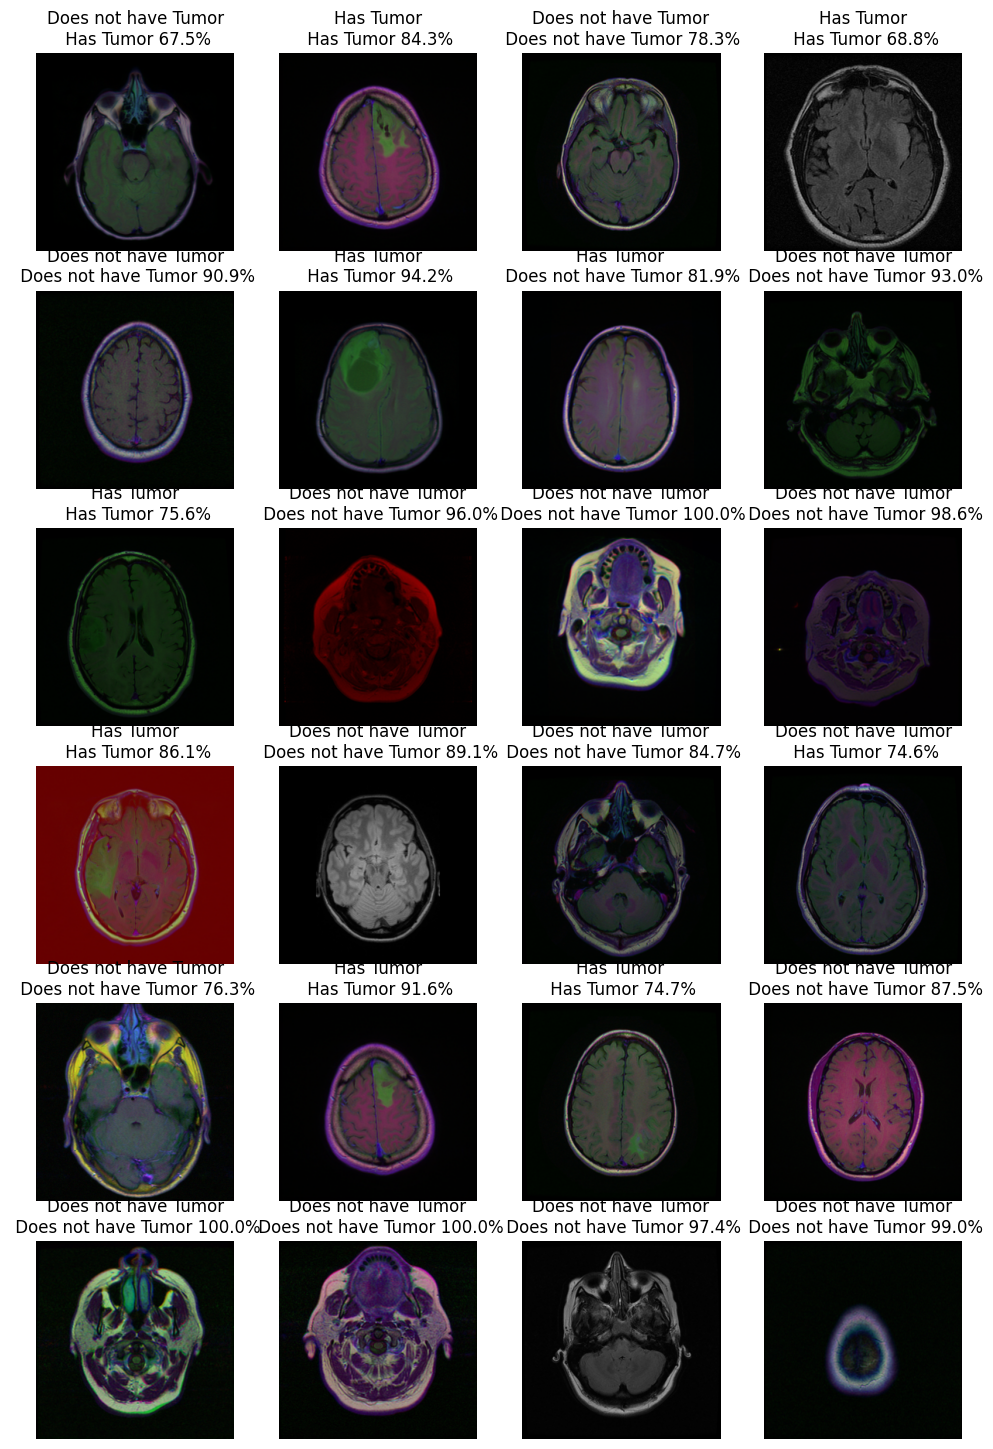

In [29]:
test_generator.reset()
x,y = next(test_generator)
plot_images(x, y, vgg16_test_preds)

# EfficientNetV2M

In [30]:
efficientNetV2M_base_model = tf.keras.applications.EfficientNetV2M( 
    include_top = False,
    weights = 'imagenet',
    input_shape = (image_height, image_width, 3)
)


In [31]:
efficientNetV2M_model = create_model(efficientNetV2M_base_model)
#efficientNetV2M_model.summary()
history1_1 = fit_model(efficientNetV2M_model, efficientNetV2M_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/3
89/89 [==============================] - 1181s 13s/step - loss: 0.6974 - accuracy: 0.4986 - val_loss: 0.7061 - val_accuracy: 0.3743
Epoch 2/3
89/89 [==============================] - 3747s 42s/step - loss: 0.6904 - accuracy: 0.5202 - val_loss: 0.6947 - val_accuracy: 0.4379
Epoch 3/3
89/89 [==============================] - 1076s 12s/step - loss: 0.6922 - accuracy: 0.5117 - val_loss: 0.6825 - val_accuracy: 0.6794


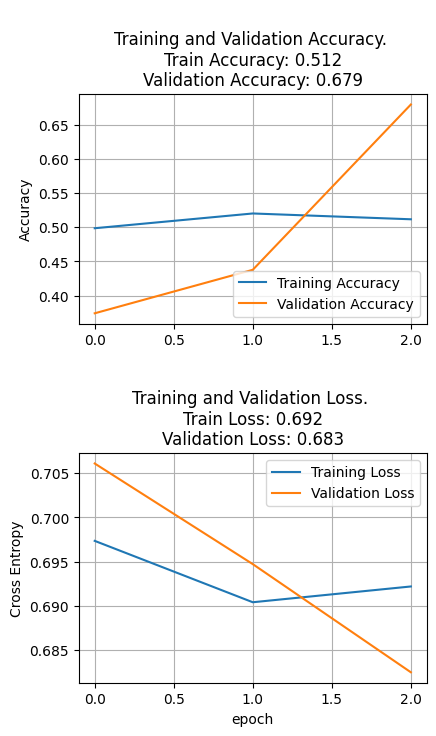

In [32]:
plot_history(history1_1)

In [33]:
nr_base_layers = len(efficientNetV2M_base_model.layers)
print("efficientNetV2M base layers = ", nr_base_layers)    

history1 = fit_model(efficientNetV2M_model, efficientNetV2M_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

efficientNetV2M base layers =  740
Unfreezing number of layers in base model =  185
Epoch 1/7
89/89 [==============================] - 2033s 22s/step - loss: 0.8055 - accuracy: 0.5771 - val_loss: 0.7177 - val_accuracy: 0.4124
Epoch 2/7
89/89 [==============================] - 22575s 256s/step - loss: 0.6829 - accuracy: 0.5431 - val_loss: 0.6966 - val_accuracy: 0.4887
Epoch 3/7
89/89 [==============================] - 1940s 22s/step - loss: 0.6185 - accuracy: 0.6354 - val_loss: 0.6695 - val_accuracy: 0.5734
Epoch 4/7
89/89 [==============================] - 2048s 23s/step - loss: 0.5842 - accuracy: 0.6673 - val_loss: 0.6439 - val_accuracy: 0.6158
Epoch 5/7
89/89 [==============================] - 2202s 25s/step - loss: 0.5842 - accuracy: 0.6687 - val_loss: 0.5847 - val_accuracy: 0.6737
Epoch 6/7
89/89 [==============================] - 2090s 23s/step - loss: 0.5453 - accuracy: 0.6931 - val_loss: 0.5718 - val_accuracy: 0.6864
Epoch 7/7
89/89 [==============================] - 1881s 21s/s

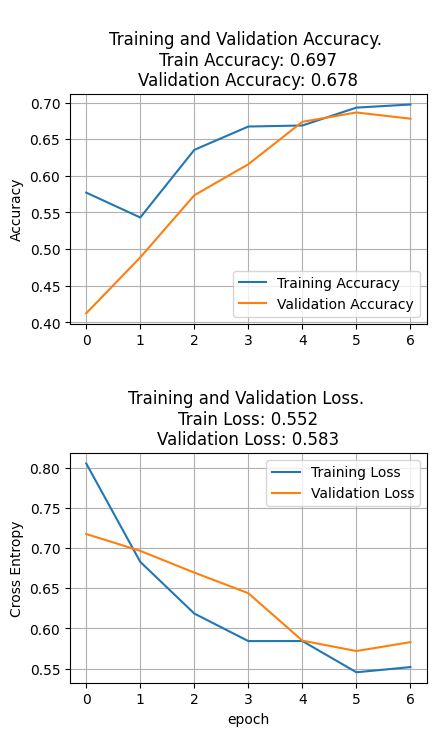

In [34]:
plot_history(history1)

In [35]:
accuracy_score = efficientNetV2M_model.evaluate(test_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

13/13 [==============================] - 136s 10s/step - loss: 0.5402 - accuracy: 0.6997
[0.5401719808578491, 0.6997455358505249]
Accuracy: 69.97%
Loss: 0.540


In [36]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

efficientNetV2M_test_preds = efficientNetV2M_model.predict(test_generator)
efficientNetV2M_test_pred_classes = np.argmax(efficientNetV2M_test_preds, axis=1)

13/13 [==============================] - 157s 11s/step


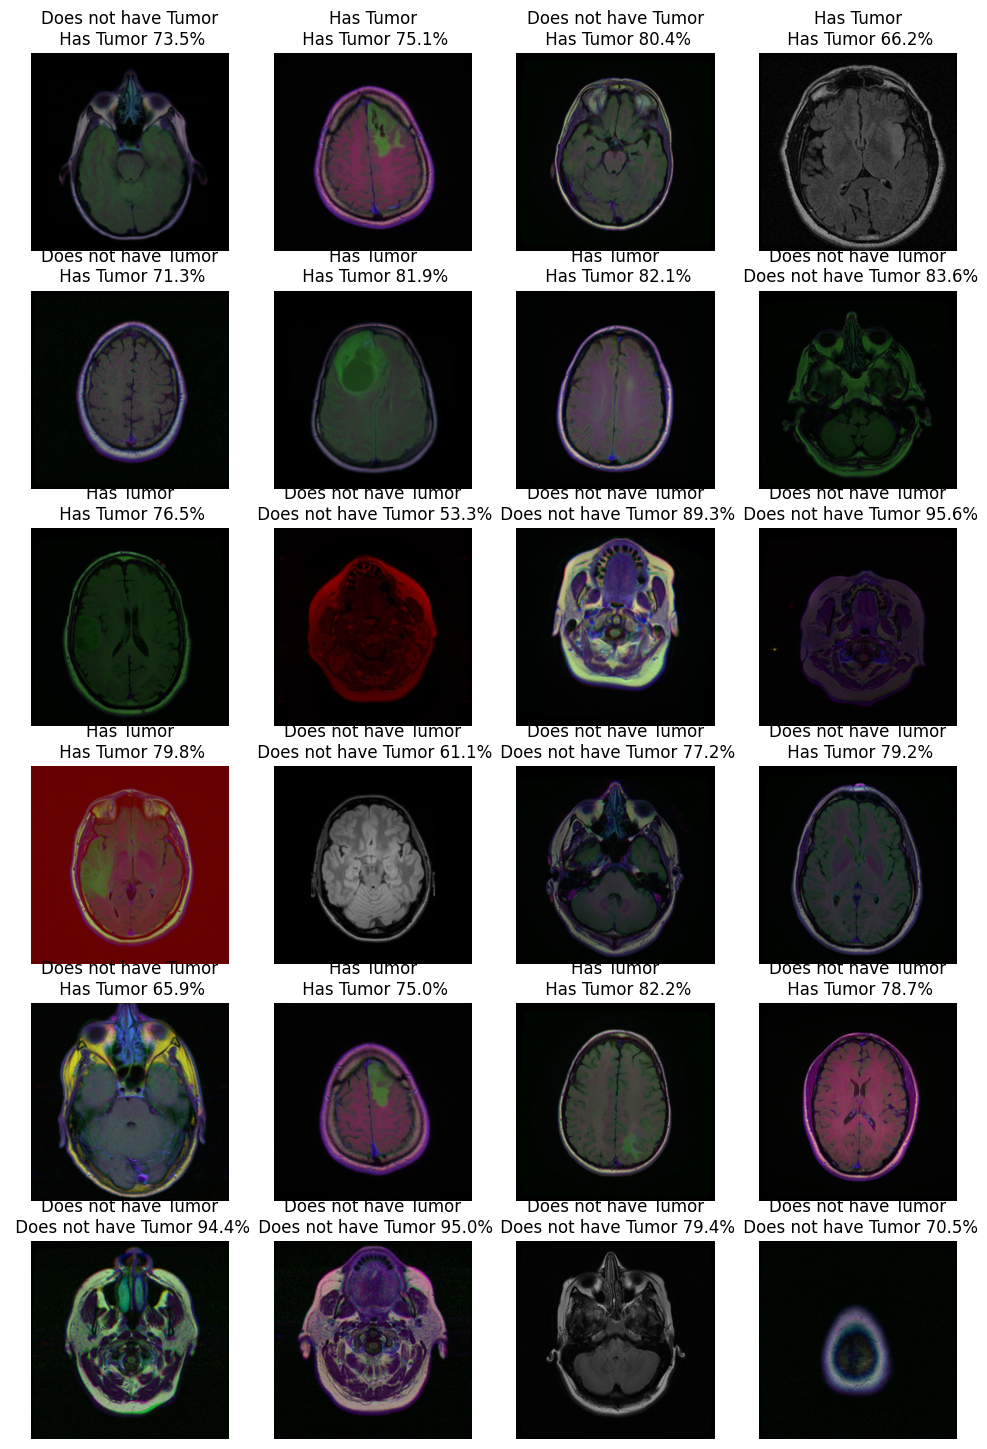

In [37]:
test_generator.reset()
x,y = next(test_generator)
plot_images(x, y, efficientNetV2M_test_preds)

In [41]:
# save model and architecture to single file
vgg16_model.save("vgg16model.h5")
print("Saved vgg16model to disk")

Saved vgg16model to disk


In [42]:
# save model and architecture to single file
efficientNetV2M_model.save("efficientNetV2Mmodel.h5")
print("Saved efficientNetV2Mmodel to disk")

Saved efficientNetV2Mmodel to disk


# DenseNet201

In [43]:
# load the DenseNet201 architecture with imagenet weights as base
DenseNet201_base_model = tf.keras.applications.DenseNet201(
    include_top = False,
    weights = 'imagenet',
    input_shape = (image_height, image_width, 3)
)


DenseNet201_model = create_model(DenseNet201_base_model)
#DenseNet201_model.summary()
history2_1 = fit_model(DenseNet201_model, DenseNet201_base_model, epochs = TRAINING_EPOCHS)

Unfreezing number of layers in base model =  0
Epoch 1/3
89/89 [==============================] - 1005s 11s/step - loss: 0.5385 - accuracy: 0.7252 - val_loss: 0.4887 - val_accuracy: 0.7669
Epoch 2/3
89/89 [==============================] - 995s 11s/step - loss: 0.4318 - accuracy: 0.7748 - val_loss: 0.4433 - val_accuracy: 0.7514
Epoch 3/3
89/89 [==============================] - 937s 11s/step - loss: 0.4027 - accuracy: 0.7811 - val_loss: 0.3665 - val_accuracy: 0.8220


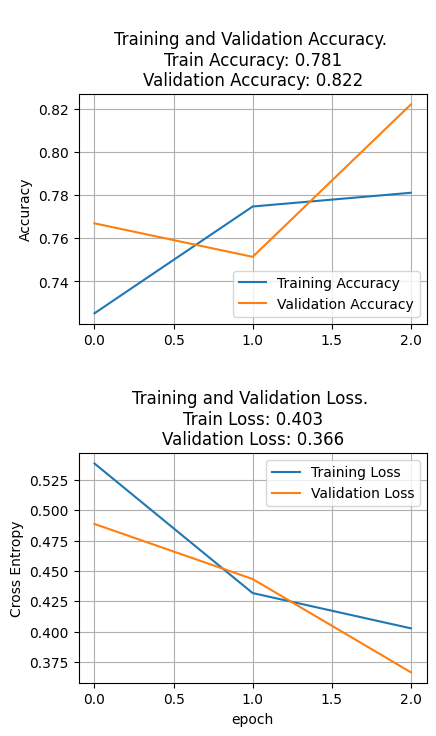

In [44]:
plot_history(history2_1)

In [45]:
nr_base_layers = len(DenseNet201_base_model.layers)
print("DenseNet201 base layers = ", nr_base_layers)    

history2 = fit_model(DenseNet201_model, DenseNet201_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

DenseNet201 base layers =  707
Unfreezing number of layers in base model =  176
Epoch 1/7
89/89 [==============================] - 1052s 11s/step - loss: 1.1097 - accuracy: 0.7412 - val_loss: 0.4171 - val_accuracy: 0.7966
Epoch 2/7
89/89 [==============================] - 954s 11s/step - loss: 0.5343 - accuracy: 0.7953 - val_loss: 0.4030 - val_accuracy: 0.7994
Epoch 3/7
89/89 [==============================] - 9275s 105s/step - loss: 0.4114 - accuracy: 0.8221 - val_loss: 0.3579 - val_accuracy: 0.7980
Epoch 4/7
89/89 [==============================] - 994s 11s/step - loss: 0.3613 - accuracy: 0.8250 - val_loss: 0.3329 - val_accuracy: 0.8023
Epoch 5/7
89/89 [==============================] - 1076s 12s/step - loss: 0.3318 - accuracy: 0.8228 - val_loss: 0.3153 - val_accuracy: 0.8291
Epoch 6/7
89/89 [==============================] - 887s 10s/step - loss: 0.3319 - accuracy: 0.8331 - val_loss: 0.3074 - val_accuracy: 0.8418
Epoch 7/7
89/89 [==============================] - 947s 11s/step - los

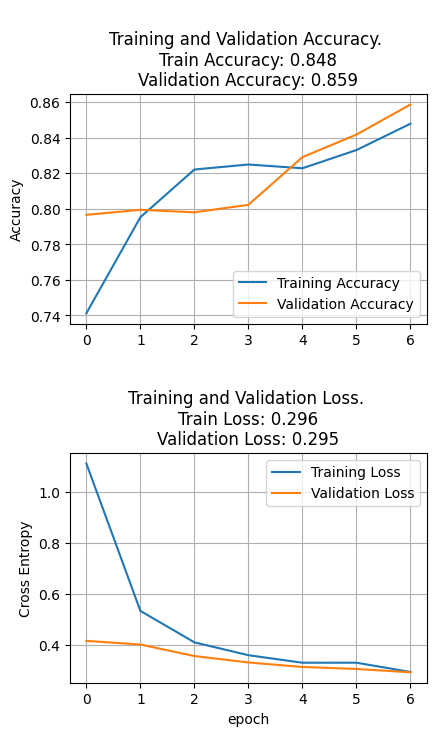

In [46]:
plot_history(history2)

In [47]:
accuracy_score = DenseNet201_model.evaluate(test_generator)

print(accuracy_score)
print("Accuracy: {:.2f}%".format(accuracy_score[1] * 100))
print("Loss: {:.3f}".format(accuracy_score[0]))

13/13 [==============================] - 83s 6s/step - loss: 0.2842 - accuracy: 0.8499
[0.2841896712779999, 0.8498727679252625]
Accuracy: 84.99%
Loss: 0.284


In [48]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

DenseNet201_test_preds = DenseNet201_model.predict(test_generator)
DenseNet201_test_pred_classes = np.argmax(DenseNet201_test_preds, axis=1)

13/13 [==============================] - 96s 7s/step


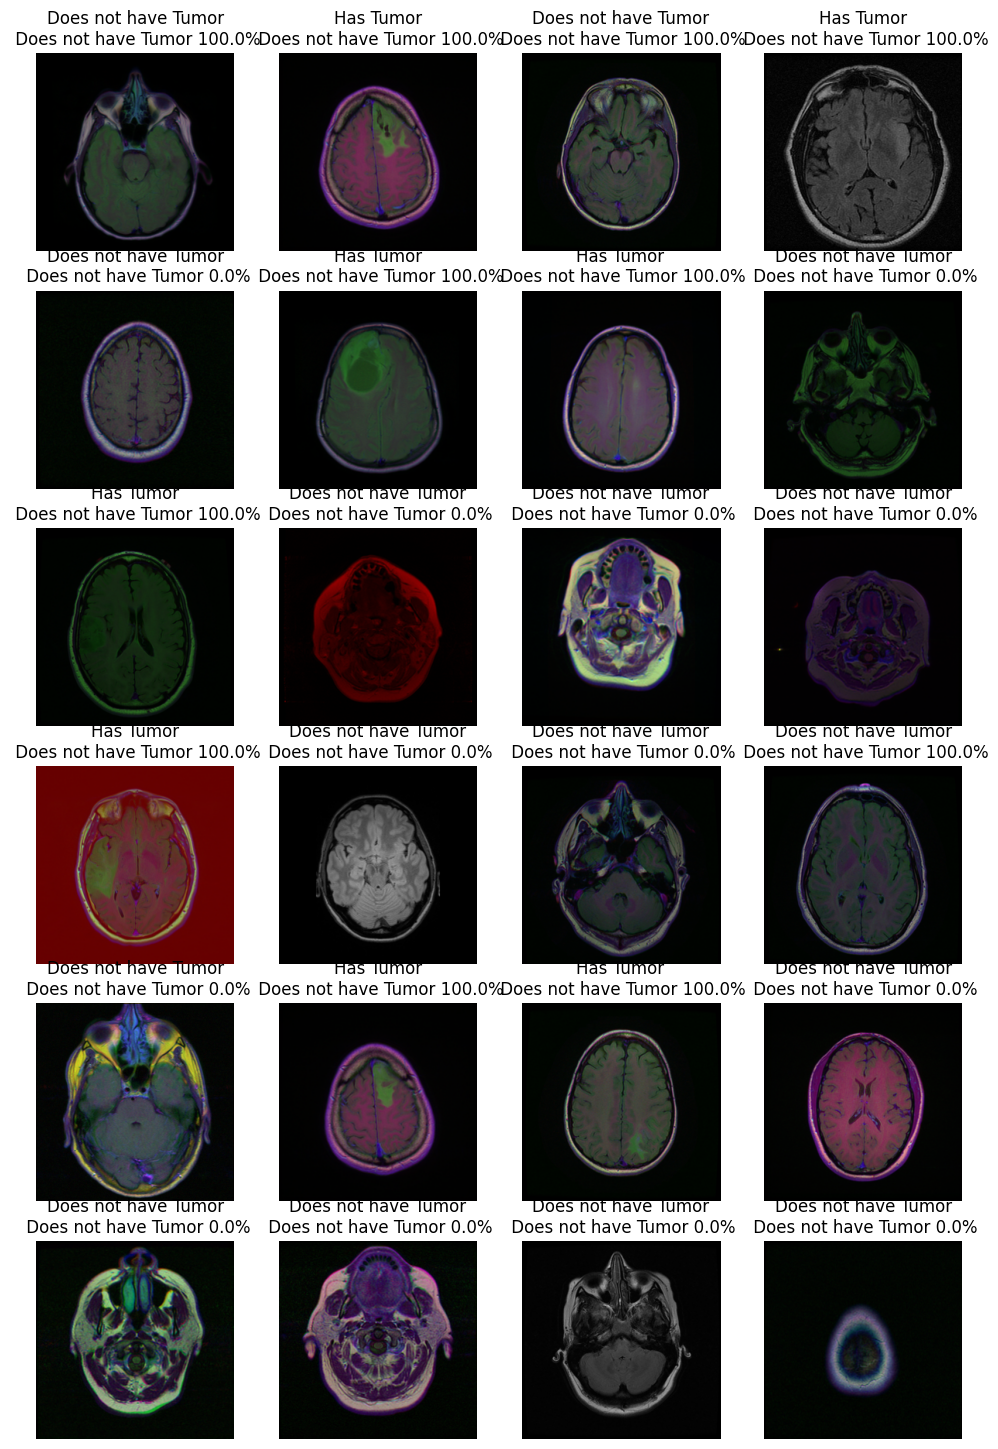

In [49]:
test_generator.reset()
x,y = next(test_generator)
plot_images(x, y, DenseNet201_test_pred_classes)

In [51]:
# save model and architecture to single file
DenseNet201_model.save("DenseNet201model.h5")
print("Saved model to disk")

Saved model to disk


In [40]:
from tensorflow.keras.models import load_model

# Assuming you have saved the trained model as a file
DenseNet201_model = load_model('DenseNet201model.h5')
efficientNetV2M_model = load_model('efficientNetV2Mmodel.h5')
vgg16_model = load_model('vgg16model.h5')

In [8]:
FINE_TUNING_EPOCHS = 7
TRAINING_EPOCHS = 3
BATCH_SIZE = 32

image_height = 256
image_width = 256

In [18]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

DenseNet201_test_preds = DenseNet201_model.predict(test_generator)
DenseNet201_test_pred_classes = np.argmax(DenseNet201_test_preds, axis=1)

13/13 [==============================] - 65s 5s/step


In [41]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

efficientNetV2M_test_preds = efficientNetV2M_model.predict(test_generator)
efficientNetV2M_test_pred_classes = np.argmax(efficientNetV2M_test_preds, axis=1)

13/13 [==============================] - 107s 8s/step


In [42]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
test_generator.reset()

vgg16_test_preds = vgg16_model.predict(test_generator)
vgg16_test_pred_classes = np.argmax(vgg16_test_preds, axis=1)

13/13 [==============================] - 171s 13s/step


In [37]:
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    
    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    
    new_title = f'{title}\n Sensitivity = {sensitivity:.2f} Specificity = {specificity:.2f}'
    
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    
    ax.set_title(new_title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

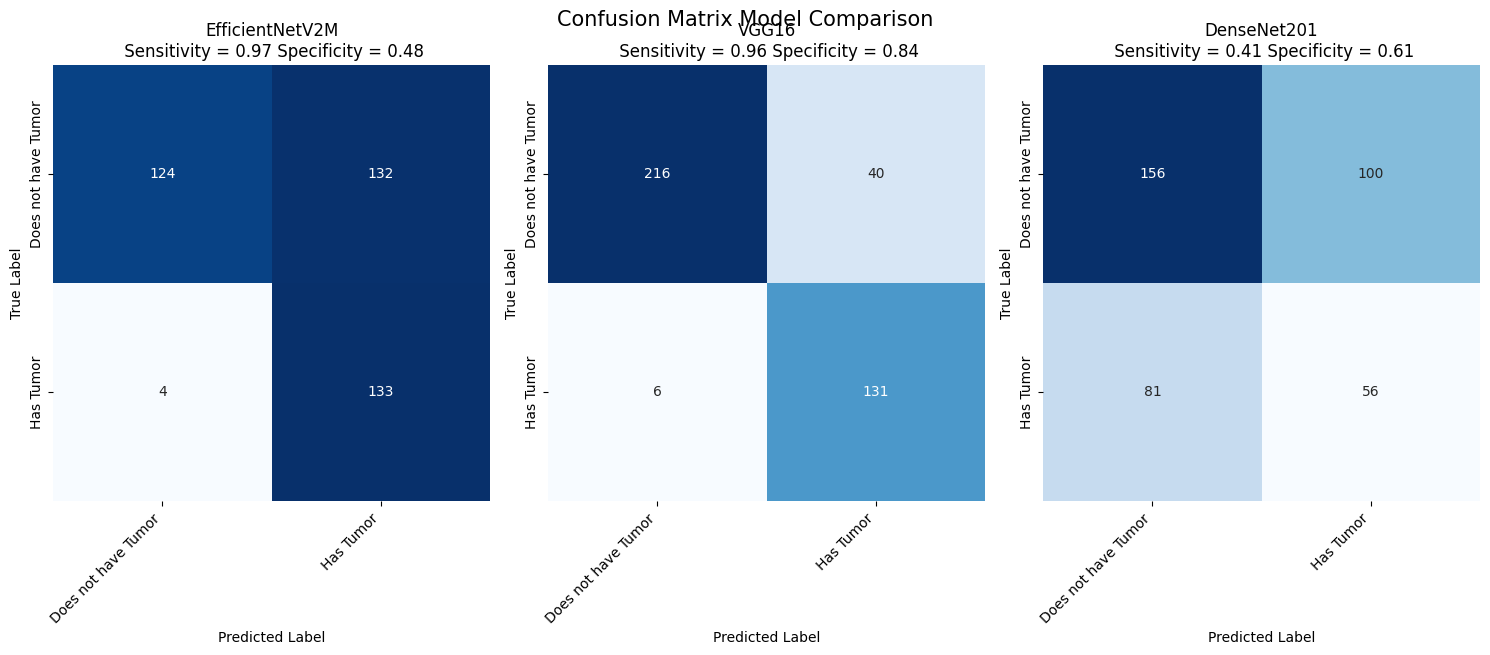

In [43]:
import seaborn as sns
# Display confusion matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

true_classes = test_generator.classes

plot_heatmap(true_classes, vgg16_test_pred_classes, class_names, ax2, title = "VGG16")  
plot_heatmap(true_classes, efficientNetV2M_test_pred_classes, class_names, ax1, title = "EfficientNetV2M")    
plot_heatmap(true_classes, DenseNet201_test_pred_classes, class_names, ax3, title = "DenseNet201")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [44]:
fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(test_generator.classes, vgg16_test_preds[:,1])
auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

In [46]:
fpr_efficient, tpr_efficient, thresholds_efficient = roc_curve(test_generator.classes, efficientNetV2M_test_preds[:,1])
auc_efficient = auc(fpr_efficient, tpr_efficient)

In [48]:
fpr_dense, tpr_dense, thresholds_dense = roc_curve(test_generator.classes, DenseNet201_test_preds[:,1])
auc_dense = auc(fpr_dense, tpr_dense)

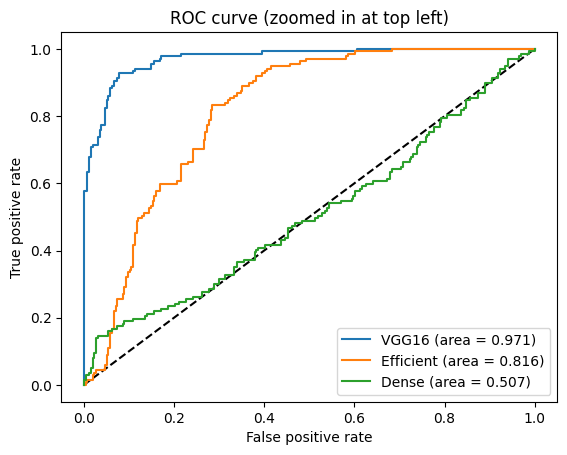

In [50]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg16, tpr_vgg16, label='VGG16 (area = {:.3f})'.format(auc_vgg16))
plt.plot(fpr_efficient, tpr_efficient, label='Efficient (area = {:.3f})'.format(auc_efficient))
plt.plot(fpr_dense, tpr_dense, label='Dense (area = {:.3f})'.format(auc_dense))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()